# Oil Spill Segmentation - Inference Notebook

This notebook loads a SAR image and predicts an oil spill segmentation mask using a trained U-Net model.

In [1]:
# Install required libraries
!pip install segmentation-models-pytorch albumentations rasterio torch torchvision

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
import albumentations as A
from skimage.transform import resize

c:\Users\Bruna\Documents\repos\oil_spill_segmentation\oil_segmentation_env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\Bruna\Documents\repos\oil_spill_segmentation\oil_segmentation_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'skimage'

In [3]:
# Load SAR image (.tif)
image_path = "C:/Users/Bruna/Documents/repos/oil_spill_segmentation/data/openEO_2017-08-10Z.tif"  # <- Update this path
with rasterio.open(image_path) as src:
    image = src.read(1).astype(np.float32)
    profile = src.profile
    transform = src.transform


In [4]:
# Preprocessing
transform_fn = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=0, std=1),
    ToTensorV2()
])
augmented = transform_fn(image=image)
input_tensor = augmented['image'].unsqueeze(0)  # Add batch dimension


In [6]:
# Load model
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, classes=1)
model.load_state_dict(torch.load("C:/Users/Bruna/Documents/repos/oil_spill_segmentation/outputs/unet_oilspill.pth", map_location="cpu"))
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [7]:
# Predict mask
with torch.no_grad():
    pred = torch.sigmoid(model(input_tensor))
    pred_mask = (pred > 0.5).float().squeeze().numpy()


In [9]:
# Resize prediction back to original image size
from skimage.transform import resize
original_shape = image.shape
resized_mask = resize(pred_mask, original_shape, preserve_range=True, anti_aliasing=True)
binary_mask = (resized_mask > 0.5).astype(np.uint8)


In [16]:
# Save georeferenced segmentation mask
output_path = "C:/Users/Bruna/Documents/repos/oil_spill_segmentation/outputs/georeferenced_segmentation_mask"
profile.update(dtype=rasterio.uint8, count=1, nodata=0)
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(binary_mask, 1)
print(f"Saved segmented mask to: {output_path}")


Saved segmented mask to: C:/Users/Bruna/Documents/repos/oil_spill_segmentation/outputs/georeferenced_segmentation_mask


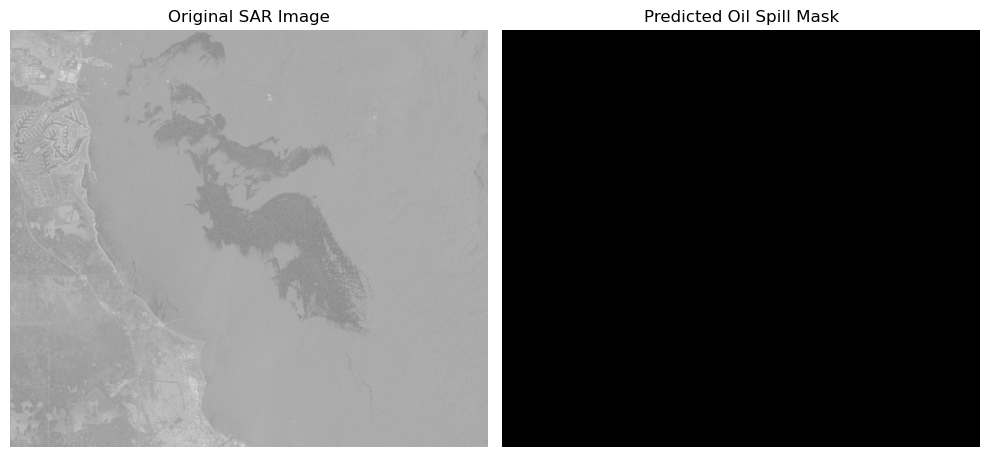

In [17]:
# Display original image and predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original SAR Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap="gray")
plt.title("Predicted Oil Spill Mask")
plt.axis("off")
plt.tight_layout()
plt.show()


In [21]:

# Convert binary mask to georeferenced polygon
import geopandas as gpd
from shapely.geometry import shape
import json
from skimage import measure

# Create contours from binary mask
contours = measure.find_contours(binary_mask, 0.5)

# Transform contours into georeferenced polygons
polygons = []
for contour in contours:
    # Transform pixel coordinates to geographic coordinates using the affine transform
    coords = [~transform * (col, row) for row, col in contour]
    polygons.append(shape({"type": "Polygon", "coordinates": [coords]}))

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs=profile["crs"])

# Save to file
geojson_output_path = "C:/Users/Bruna/Documents/repos/oil_spill_segmentation/outputs/geo_json"
gdf.to_file(geojson_output_path, driver="GeoJSON")
print(f"Saved segmentation polygons to: {geojson_output_path}")


Saved segmentation polygons to: C:/Users/Bruna/Documents/repos/oil_spill_segmentation/outputs/geo_json
